# Objective

Build a model to predict clusters for regulatory data

__Dataset Specs__: Over 1,500 data points

## Install and Import Libraries

In [4]:
# Import all libraries
import pandas as pd
import numpy as np
import re
import openpyxl

# Huggingface transformers
import transformers
from transformers import BertModel,BertTokenizer,AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import flair
import bertopic
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from keybert import KeyBERT
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from scipy.cluster import hierarchy as sch
linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
import hdbscan
from hdbscan import HDBSCAN

from transformers import LongformerTokenizer, LongformerForTokenClassification, LongformerConfig
import torch
from sklearn.cluster import KMeans
from typing import List

from flair.embeddings import DocumentPoolEmbeddings
from flair.data import Sentence
from flair.embeddings import TransformerDocumentEmbeddings

from umap import UMAP
from sklearn.preprocessing import minmax_scale
from bertopic.backend import BaseEmbedder

longform_model = TransformerDocumentEmbeddings("allenai/longformer-base-4096")
longform_tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
from transformers.pipelines import pipeline

# Define embedding model
from bertopic.backend import BaseEmbedder
from flair.embeddings import DocumentEmbeddings, TokenEmbeddings, DocumentPoolEmbeddings
from typing import List, Union
import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize

# from flair.embeddings import TransformerDocumentEmbeddings
# roberta = TransformerDocumentEmbeddings('roberta-base')

#handling html data
from bs4 import BeautifulSoup

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import minmax_scale

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/Users/thomas/opt/anaconda3/envs/flairenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Today's date
from datetime import date
TODAY_STR = date.today().strftime("%d%m%y")

## Load Datasets

In [6]:
# Load hse data
hse_rawdata_df = pd.read_excel("/Users/thomas/Documents/BEIS/input_data/181022-pdf_rawdata.xlsx")

# Sort values in source to get construction first and drop duplicates keeping the first
for loc in hse_rawdata_df.index:
    if hse_rawdata_df["Source"].iloc[loc] == "construction_PDFs_df":
        hse_rawdata_df["Source"].iloc[loc] = "A"

hse_rawdata_df = hse_rawdata_df.sort_values(by = "Source").drop_duplicates(subset = ["Secondary Legislation"], keep = "first").reset_index(drop = True)

for loc in hse_rawdata_df.index:
    if hse_rawdata_df["Source"].iloc[loc] == "A":
        hse_rawdata_df["Source"].iloc[loc] = "construction_PDFs_df"

# Rename column
hse_rawdata_df.rename(columns = {"Secondary Legislation" : "Guidance"}, inplace = True)

# Add regulators
hse_rawdata_df["Regulator"] = "HSE" 

# Cut research documents out
hse_rawdata_df = hse_rawdata_df[~hse_rawdata_df["URLs"].apply(lambda x : "research" in x)]

In [7]:
# Load ofgem data
ofgem_rawdata_df = pd.read_excel("/Users/thomas/Documents/BEIS/input_data/211022-pdf_ofgem_rawdata.xlsx")

# Rename column
ofgem_rawdata_df.rename(columns = {"Secondary Legislation" : "Guidance"}, inplace = True)

# Add regulators
ofgem_rawdata_df["Regulator"] = "Ofgem"

In [8]:
# Load EA data
ea_pdfs = pd.read_excel("/Users/thomas/Documents/BEIS/input_data/271022_ea_pdfs.xlsx").drop(columns = ["Unnamed: 0"])
ea_collections = pd.read_csv("/Users/thomas/Documents/BEIS/input_data/ea_csvs/collections.csv")
ea_govuk = pd.read_csv("/Users/thomas/Documents/BEIS/input_data/ea_csvs/govuk.csv")
ea_guidance = pd.read_csv("/Users/thomas/Documents/BEIS/input_data/ea_csvs/guidance.csv")
ea_publications = pd.read_csv("/Users/thomas/Documents/BEIS/input_data/ea_csvs/publications.csv")

csv_combined = pd.concat([ea_collections,ea_govuk,ea_guidance,ea_publications])
csv_combined.rename(columns = {"Text" : "Guidance"}, inplace = True)
ea_rawdata_df = pd.concat([csv_combined[["Guidance"]], ea_pdfs[["Guidance"]]]).reset_index(drop = True)

# Add regulators
ea_rawdata_df["Regulator"] = "EA"

In [9]:
# Combine dataframes
combined_df = pd.concat([hse_rawdata_df, ea_rawdata_df, ofgem_rawdata_df])
combined_df = combined_df[["Guidance", "Regulator"]]

## Pre-process the data

The Body column contains data in a HTML format and thus we need to strip off the HTML also we will do a lower case conversion to reduce vocabulary size

In [10]:
stop_words = stopwords.words('english')
english_stop_words = [w for w in ENGLISH_STOP_WORDS]
stop_words.extend(["use", "uses", "used", "www", "gov", "uk", "guidance", "pubns"])
stop_words.extend(english_stop_words)

In [11]:
# Define function for preprocessing of text
def pre_process(text):

  # convert text to lower case
  text = text.lower()

  # replace tabs and paragraphs
  text = text.replace("\n", " ")  
  text = text.replace("\t", " ")  

  # remove html tags
  text = re.sub('<.*?>', "", text)
  text = text.replace("_x000c_", "")

  return text

In [12]:
# Clean the text in Body column
combined_df["Clean Text"] = combined_df["Guidance"].apply(lambda x: pre_process(x)).dropna()

# Drop if exmpty string
combined_df = combined_df[combined_df["Clean Text"] != ""]

Cut data down to just construction industry by using keyword searches for construction terms

In [13]:
# If construction terms appears in text, add 1 to list
construction_terms = ["adhesive", "accessbility", "addendum", "aggregate", "architect", "area", "backfilling", "beam",
"bid", "bid package", "bid selection", "blueprint", "building", "building code", "building engineer", "building information modeling", 
"bim", "cad", "caulk", "change order", "circuit breaker", "concrete", "construction drawing", "construction", "construction estimate", 
"construction management", "demolition", "dimensions", "dimension", "drill", "drywall", "ducts", "duct", "floor", "footprint", "foundation", 
"gantt", "general contractor", "guaranteed maximum price", "gmp", "hvac", "inspection", "insulation", "jigsaw", "job costing", "load-bearing",
"lot", "nonbearing", "pallet", "particle", "perimeter", "paint", "painting", "ladder", "coshh", "perimeter", "plat", "plywood", "project manager", "public-private partnership",
"ppp", "pvc", "rafter", "renovation", "request for information", "rfi", "request for proposal", "residential", "infrastructure", "rfp", "request for quote", "rfq", "specifications", "table saw",
"trim", "veneer", "warping", "zoning", "heavy", "project controller", "surveyor", "contracts manager", "commercial manager", "design", "engineer", "site", "planner", "metal",
"plywood", "decking", "concrete", "fibre", "cladding", "glass", "wood", "cement", "aggregates", "stones", "rocks", "mud", "clay", "brick", "bricks", "plastic", "foam", "fabric", "thatch", "timber",
"tiles", "kevlar", "bamboo", "carbon", "electrical", "material", "materials", "plumbing", "pipe", "pipes", "waste", "sewage", "gas"]

construction_appears = []
for text in combined_df["Clean Text"]:
    x = 0
    for word in construction_terms:
        if word in text:
            x = 1
    construction_appears.append(x)

In [14]:
# Take subset of rawdata df and add a column for if construction was tagged
combined_df["Construction Tagged"] = construction_appears

In [15]:
# Cut lines out with no construction terms
combined_df = combined_df[combined_df["Construction Tagged"] == 1].reset_index(drop = True)

In [16]:
# View df
combined_df.head()

,Guidance,Regulator,Clean Text,Construction Tagged
0,Health and Safety \nExecutive\n\nOld lead pai...,HSE,health and safety executive old lead paint ...,1
1,"Your health, your safety\nA brief guide for wo...",HSE,"your health, your safety a brief guide for wor...",1
2,Health and Safety \n\nWorking with display sc...,HSE,health and safety working with display scre...,1
3,Health and Safety \nExecutive \n\nThorough exa...,HSE,health and safety executive thorough examin...,1
4,Health and Safety \nExecutive\n\nManaging hea...,HSE,health and safety executive managing health...,1


In [17]:
# Cut non english documents out
from langdetect import detect
combined_df = combined_df[combined_df["Clean Text"].apply(lambda x : detect(x)) == "en"]

# Concat the two dataframes together
training_data = combined_df.reset_index(drop = True)

# Split longer documents if longer than 3000 tokens (limit is 4000)

(array([920., 615.,  15.,   6.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([   50.,  3544.,  7038., 10532., 14026., 17520., 21014., 24508.,
        28002., 31496., 34990.]),
 <BarContainer object of 10 artists>)

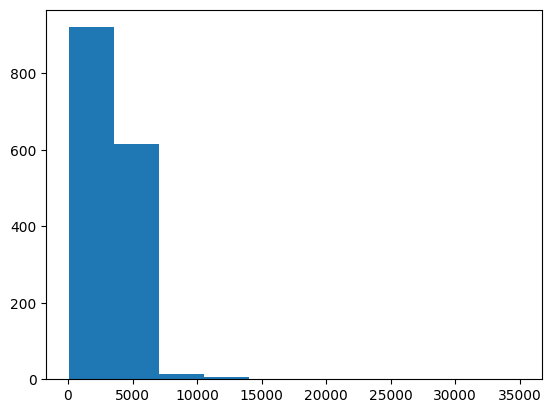

In [18]:
# Get lengths of tokenized data
plt.hist(training_data["Clean Text"].apply(lambda x: len(word_tokenize(x))))

In [19]:
# Define a function to split text
def split_list(a, n):
    """
    Function to split the content into list of chunks of size n
    :param a: list of words
    :param n: size of the chunks
    """
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

In [23]:
# Splitting docs into points less than 4000 tokens long to conform to longformers input length
# Make note of original index so that we can assign the whole documents to the topic with the highest probability
extended_docs = []
indeces = []
for idx in training_data["Clean Text"].index:
    doclength = len(word_tokenize(training_data["Clean Text"].iloc[idx]))
    number_to_split_into = round(doclength/3000 + 0.5) #round up
    if number_to_split_into <= 1:
        extended_docs.append(training_data["Clean Text"].iloc[idx])
        indeces.append(idx)
    else:
        split_docs = list(split_list(training_data["Clean Text"].iloc[idx], number_to_split_into))
        for num_docs in range(0, number_to_split_into):
            extended_docs.append(split_docs[num_docs])
            indeces.append(idx)

# Get docs to use for BertTopic based on chunked documents
docs = extended_docs.copy()
docs = [x for x in docs if x != ""]

# Dataframe of docs with indeces
docs_with_indeces_df = pd.DataFrame({"Documents" : docs, "Indeces" :indeces})

# Get length
len(docs)

2321

# Apply longformer model for embeddings and find optimal number of clusters

In [175]:
# Take random sample of data
from random import sample, seed
seed(10)
sampled_docs = sample(docs, 1000)

In [29]:
# Define embeddings model
embedding_model = pipeline("feature-extraction", model="allenai/longformer-base-4096")

In [269]:
# Get embeddings and normalise the same way BERTopic does
import tqdm
from torch.utils.data import Dataset

class DefineDataset(Dataset):
    """ Dataset to pass to `transformers.pipelines.pipeline` """
    def __init__(self, docs):
        self.docs = docs

    def __len__(self):
        return len(self.docs)

    def __getitem__(self, idx):
        return self.docs[idx]

class HFTransformerBackend(BaseEmbedder):

    def __init__(self, embedding_model: Pipeline):
        super().__init__()

        if isinstance(embedding_model, Pipeline):
            self.embedding_model = embedding_model
        else:
            raise ValueError("Please select a correct transformers pipeline. For example: "
                                "pipeline('feature-extraction', model='distilbert-base-cased', device=0)")
    def embedder(self,
                document: str,
                features: np.ndarray) -> np.ndarray:
        token_embeddings = np.array(features)
        attention_mask = self.embedding_model.tokenizer(document, truncation=True, padding=True, return_tensors="np")["attention_mask"]
        input_mask_expanded = np.broadcast_to(np.expand_dims(attention_mask, -1), token_embeddings.shape)
        sum_embeddings = np.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = np.clip(input_mask_expanded.sum(1), a_min=1e-9, a_max=input_mask_expanded.sum(1).max())
        embedding = normalize(sum_embeddings / sum_mask)[0]
        return embedding

    def embed(self,
                documents: List[str],
                verbose: bool = False) -> np.ndarray:
        dataset = DefineDataset(documents)
        embeddings = []
        for document, features in zip(documents, self.embedding_model(dataset, truncation=True, padding=True)):
            embeddings.append(embedder(document, features))
        return np.array(embeddings)

custom_backend = HFTransformerBackend(embedding_model)

In [270]:
# Get embeddings for sample embeddings
def embed_example_docs(docs : List):
    embeddings = []
    for documents, features in zip(docs, embedding_model(DefineDataset(docs), truncation=True, padding=True)):
        embeddings.append(custom_backend.embedder(documents, features))
    return np.array(embeddings)

In [271]:
# Get sample embeddings
sample_embeddings = embed_example_docs(sampled_docs)

### Dimensionality Reduction

In [461]:
# Both PCA and UMAP were tried and the silhouette score checked - UMAP led to more clusters being recommended by all models trialled (BERTopic authors recommended), therefore umap was used. 
from sklearn.decomposition import PCA
pca_result = PCA(n_components = 2).fit_transform(sample_embeddings)
pca_result_higher_dimension = PCA(n_components = 5).fit_transform(sample_embeddings)

# Try UMAP
reducer = UMAP(random_state = 42, n_neighbors = 10, min_dist = 0.0, n_components = 4, metric = "manhattan") 
umap_results = reducer.fit_transform(sample_embeddings)

## Kmeans

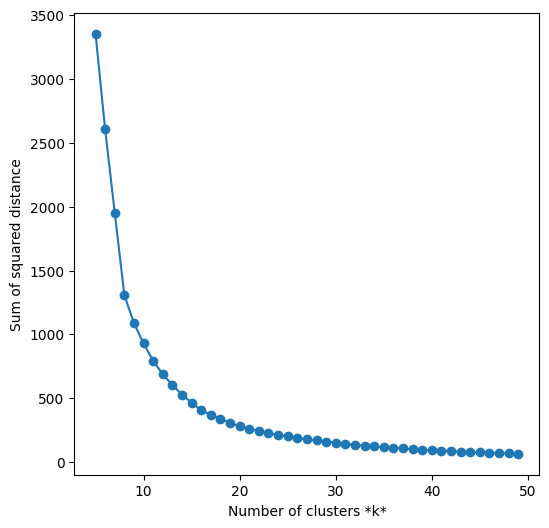

In [363]:
# Get optimum number of clusters at the bend
sse = []
list_k = list(range(5, 50))

for k in list_k:
    km = KMeans(n_clusters=k, random_state = 42)
    km.fit(umap_results)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [462]:
from sklearn.metrics import silhouette_score

# Calculate Silhoutte Score
scores = []
for k in range(2, 20):
    km = KMeans(n_clusters = k)
    km.fit(umap_results)
    silh_score = silhouette_score(umap_results, km.labels_, metric='euclidean')
    scores.append((silh_score, k))

In [463]:
# Silhouette scores with clusters
scores

[(0.59226656, 2),
 (0.63611484, 3),
 (0.6706242, 4),
 (0.6793253, 5),
 (0.59752136, 6),
 (0.6157916, 7),
 (0.56237, 8),
 (0.5734887, 9),
 (0.58124495, 10),
 (0.535126, 11),
 (0.51764035, 12),
 (0.49937573, 13),
 (0.50762826, 14),
 (0.5157408, 15),
 (0.536442, 16),
 (0.5423457, 17),
 (0.54612035, 18),
 (0.53815794, 19)]

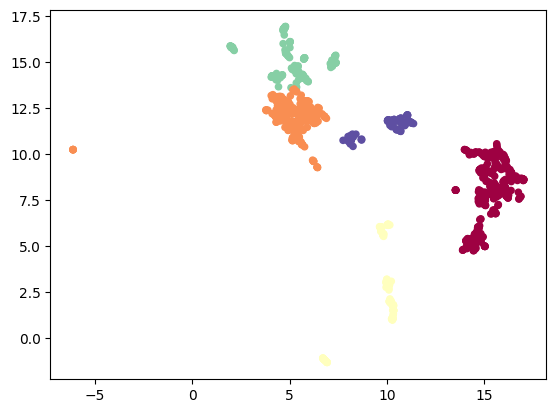

In [362]:
# View scatter graph
visualise_reducer = UMAP(random_state = 42, n_neighbors = 10, min_dist = 0.0, n_components = 2, metric = "manhattan") 
visualise_umap_results = visualise_reducer.fit_transform(sample_embeddings)

km = KMeans(n_clusters = 5)
km.fit(visualise_umap_results)
data = visualise_umap_results
labels = km.labels_

plt.scatter(data[:, 0], data[:, 1], c=labels, s=20, cmap='Spectral')
plt.show()

## Agglomerative Clustering

In [393]:
from sklearn.cluster import AgglomerativeClustering

In [433]:
# Calculate Silhoutte Score
agg_scores = []
for k in range(2, 20):
    km = AgglomerativeClustering(n_clusters = k)
    km.fit(umap_results)
    silh_score = silhouette_score(umap_results, km.labels_, metric='euclidean')
    agg_scores.append((silh_score, k))

# View scores
agg_scores

[(0.6080414, 2),
 (0.63611484, 3),
 (0.6706242, 4),
 (0.6793253, 5),
 (0.59752136, 6),
 (0.6157916, 7),
 (0.56695825, 8),
 (0.5790092, 9),
 (0.5865068, 10),
 (0.5336565, 11),
 (0.52240443, 12),
 (0.54520714, 13),
 (0.5005118, 14),
 (0.52395326, 15),
 (0.5295134, 16),
 (0.5301384, 17),
 (0.5363129, 18),
 (0.5246253, 19)]

## Bisecting KMeans

In [429]:
from sklearn.cluster import BisectingKMeans

In [432]:
# Calculate Silhoutte Score
bk_scores = []
for k in range(2, 20):
    km = AgglomerativeClustering(n_clusters = k)
    km.fit(umap_results)
    silh_score = silhouette_score(umap_results, km.labels_, metric='euclidean')
    bk_scores.append((silh_score, k))

# View scores
bk_scores

[(0.6080414, 2),
 (0.63611484, 3),
 (0.6706242, 4),
 (0.6793253, 5),
 (0.59752136, 6),
 (0.6157916, 7),
 (0.56695825, 8),
 (0.5790092, 9),
 (0.5865068, 10),
 (0.5336565, 11),
 (0.52240443, 12),
 (0.54520714, 13),
 (0.5005118, 14),
 (0.52395326, 15),
 (0.5295134, 16),
 (0.5301384, 17),
 (0.5363129, 18),
 (0.5246253, 19)]

It does not matter which model you choose, all give highest scores at 5 clusters

# BERTopic

In [32]:
import torch.nn.functional as F

In [364]:
from transformers.pipelines import pipeline
from sklearn.decomposition import PCA

# Define hdbscan model to reduce outliers generated
hdbscan_model = HDBSCAN(min_cluster_size=20, metric='manhattan', 
                        cluster_selection_method='eom', prediction_data=True, min_samples=10) # min sample size reduces number of generated outliers
# Define UMAP
reducer = UMAP(random_state = 42, n_neighbors = 10, min_dist = 0.0, n_components = 4, metric = "manhattan") 

# Define a clustering model that does not produce outliers
from sklearn.cluster import KMeans
cluster_model = KMeans(n_clusters=5, random_state = 42) # As specified by the silhouette method

In [365]:
# Fit BertTopic and get top 10 words in each document by frequency

# Define sentence model and embeddings
# sentence_model = SentenceTransformer("xlm-r-bert-base-nli-stsb-mean-tokens")
# embeddings = sentence_model.encode(docs, show_progress_bar=False)

# To make the model more robust to stopwords bm25_weighting = True. Possible addition: reduce frequent words that aren't considered stopwords (reduce_frequent_words=True)
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Preprocess data after embeddings are created
def pre_process_tokenization_function(text):
    text = BeautifulSoup(text).get_text()
    # fetch alphabetic characters
    text = re.sub("[^a-zA-Z]", " ", text)
    # define stopwords
    remove_stop_words = set(stop_words)
    # tokenize 
    word_tokens = word_tokenize(text)
    filtered_sentence = []
    for w in word_tokens:
        if w not in remove_stop_words:
            filtered_sentence.append(w)
    # # Remove any small characters remaining
    filtered_sentence = [word for word in filtered_sentence if len(word) > 1]
    # # Lemmatise text
    lemmatised_sentence = [wnl.lemmatize(word) for word in filtered_sentence]
    return lemmatised_sentence

# Define vectorizer model for topic representation
vectorizer_model= CountVectorizer(stop_words="english", tokenizer = pre_process_tokenization_function) # prevents noise and improves representation of clusters

# Fit the models
topic_model = BERTopic(language = "english", 
top_n_words=10, 
diversity=0.5, 
# min_topic_size = 5, 
embedding_model= embedding_model,
umap_model= reducer,
hdbscan_model = cluster_model, # adding in a custom hdbscan that will reduce outliers / if kmeans, no outliers but maximum number of dimensions to reduce to is 10
vectorizer_model=vectorizer_model)

In [366]:
# Fit and get predictions
topics, probs = topic_model.fit_transform(docs)

In [371]:
# Add this to the input df
docs_with_indeces_df["Topics"] = topics
docs_with_indeces_df["Probabilities"] = probs

# Get topics with highest probabilities
docs_with_indeces_sorted_df = docs_with_indeces_df.sort_values("Probabilities", ascending = False).drop_duplicates(subset = "Indeces", keep = "first")

# Dictionary of topics with keys and map to df
topic_keys_dict = dict(zip(topic_model.get_topic_info()["Topic"], topic_model.get_topic_info()["Name"]))
docs_with_indeces_sorted_df["Topics"] = docs_with_indeces_sorted_df["Topics"].map(topic_keys_dict)

# Combine with training data df
output_df = training_data[["Clean Text", "Regulator"]].reset_index()
output_df = output_df.merge(docs_with_indeces_sorted_df, how = "left", left_on = "index", right_on = "Indeces")

In [373]:
# Get most important words from a document using TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english', max_features=15)
important_doc_words = []
for text in training_data["Clean Text"]:
    X = vectorizer.fit([" ".join(pre_process_tokenization_function(text))])
    important_doc_words.append(vectorizer.get_feature_names_out())

In [377]:
# Add most frequent words to docs with topics dataframe
output_df["Most Frequent Words"] = [list(freq_word_array) for freq_word_array in important_doc_words]

# Output dataframe to view data
path = "/Users/thomas/Documents/BEIS/doc_classification/output"
output_df.to_excel(f"{path}/{TODAY_STR}-kmeans-inspect_topics_5clusters_hdbscan_tuned.xlsx")

In [378]:
# Save model
topic_model.save(f"/Users/thomas/Documents/BEIS/doc_classification/models/{TODAY_STR}_bertopic_longformer_div0.5_mintop5_vectorized_kmeans")

## Hierarchical topics

In [387]:
# Hierarchical topics
from scipy.cluster import hierarchy as sch
linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
hierarchical_topics = topic_model.hierarchical_topics(docs)

100%|██████████| 4/4 [00:43<00:00, 10.84s/it]


In [388]:
# Get hierarchical tree
tree = topic_model.get_topic_tree(hierarchical_topics)
print(tree)

.
├─hse_equipment_exposure_executive_assessment
│    ├─■──equipment_coshh_provide_exposure_substance ── Topic: 2
│    └─■──equipment_hse_executive_assessment_employee ── Topic: 1
└─ofgem_electricity_supplier_waste_licence
     ├─waste_permit_assessment_emission_environmental
     │    ├─■──waste_environment_permit_emission_assessment ── Topic: 3
     │    └─■──waste_exemption_permit_april_hfc ── Topic: 4
     └─■──ofgem_electricity_supplier_licence_customer ── Topic: 0



In [446]:
# Get topics
topic_freq = []
for i in range(0, 5):
    topic_freq.append(topic_model.get_topic(topic_model.get_topic_freq().iloc[i].Topic))
pd.DataFrame(topic_freq).T

,0,1,2,3,4
0,"(ofgem, 0.045906582995426916)","(equipment, 0.02188167669404022)","(equipment, 0.04168776372049086)","(waste, 0.07569532759026437)","(waste, 0.09369797713819579)"
1,"(electricity, 0.035797825412773966)","(hse, 0.021563538930057493)","(coshh, 0.04009775717131994)","(environment, 0.039903275598203364)","(exemption, 0.041316321082607604)"
2,"(supplier, 0.032496339465159)","(executive, 0.017205812099988185)","(provide, 0.03768586089017929)","(permit, 0.033107295313343284)","(permit, 0.030034140560257497)"
3,"(licence, 0.025165543668512723)","(assessment, 0.01598755932055358)","(exposure, 0.0335746154297684)","(emission, 0.023941845534606324)","(april, 0.026338431574672447)"
4,"(customer, 0.02503033100597192)","(employee, 0.014650621287068104)","(substance, 0.028406051981464155)","(assessment, 0.022842422371102414)","(hfc, 0.025905204126708388)"
5,"(scheme, 0.023252669283073516)","(exposure, 0.01318224882226362)","(protective, 0.02835272502993997)","(penalty, 0.0190313483653226)","(treat, 0.02190274271594669)"
6,"(obligation, 0.021878616674406527)","(people, 0.012911027101540896)","(surveillance, 0.027407200105817334)","(receptor, 0.017336921715867995)","(environmental, 0.019499973527130742)"
7,"(licensee, 0.02107959785644796)","(employer, 0.012797742146273394)","(hazardous, 0.026863518533855508)","(monitoring, 0.01676519060867844)","(flood, 0.015446311278755552)"
8,"(requirement, 0.01754464940568093)","(safe, 0.012784098688807014)","(asbestos, 0.024340966488609166)","(groundwater, 0.016274593506231463)","(quota, 0.015234370157891605)"
9,"(provide, 0.015660126027784868)","(activity, 0.012776787585883251)","(glove, 0.024130640736349337)","(england, 0.015550094691363722)","(hazardous, 0.015195731288309642)"


## Other model info

In [389]:
# See top 10 topics in first doc
topic_model.get_topic(topic_model.get_topic_freq().iloc[4].Topic)

[('waste', 0.09369797713819579),
 ('exemption', 0.041316321082607604),
 ('permit', 0.030034140560257497),
 ('april', 0.026338431574672447),
 ('hfc', 0.025905204126708388),
 ('treat', 0.02190274271594669),
 ('environmental', 0.019499973527130742),
 ('flood', 0.015446311278755552),
 ('quota', 0.015234370157891605),
 ('hazardous', 0.015195731288309642)]

In [386]:
# Get overall topic info
topic_model.get_topic_info().head()

,Topic,Count,Name
0,0,859,0_ofgem_electricity_supplier_licence
1,1,788,1_equipment_hse_executive_assessment
2,2,316,2_equipment_coshh_provide_exposure
3,3,188,3_waste_environment_permit_emission
4,4,170,4_waste_exemption_permit_april


In [447]:
# Find topics with construction
topic_model.find_topics("construction")

([2, 1, 3, 4, 0],
 [0.986801052432251,
  0.9857693311261086,
  0.9840503530212842,
  0.9836867850093204,
  0.9836189530247685])